# data

Load OHLC data from cryptocurrency exchange Poloniex

In [1]:
from vectorbt import data, graphics
from datetime import datetime
from importlib import reload
import pytz
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 5)

In [2]:
ohlc_df = data.load_cryptopair('USDT_BTC', data.ago_dt(days=30), data.now_dt())
ohlc_df.head()

passed. 1.25s


,O,H,L,C,V
date,,,,,
2017-10-21 21:25:00,6084.499858,6099.000000,6084.499857,6095.000000,47574.576533
2017-10-21 21:30:00,6087.499857,6100.000000,6080.520000,6085.900450,72200.145272
2017-10-21 21:35:00,6085.900449,6086.001926,6069.979952,6070.583807,50441.803581
2017-10-21 21:40:00,6070.583807,6078.000000,6054.000000,6067.000000,114443.746221
2017-10-21 21:45:00,6067.000000,6077.999999,6060.000000,6071.846615,12362.447888


In [3]:
rate_sr = ohlc_df['O']

    count         mean         std      min          25%          50%     75%  \
O  8640.0  6689.945575  752.495329  5302.64  5951.936245  6657.698002  7300.0   

      max  
O  8284.0  


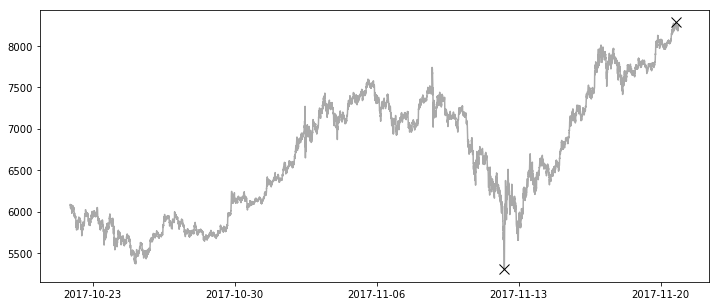

In [4]:
graphics.plot_line(rate_sr)

## indicators

Calculate simple moving averages

In [5]:
from vectorbt import indicators

In [6]:
fast_ma_sr = indicators.EMA(rate_sr, 50)
slow_ma_sr = indicators.EMA(rate_sr, 100)
print(fast_ma_sr.head())
print(slow_ma_sr.head())

date
2017-10-21 21:25:00    6084.499858
2017-10-21 21:30:00    6084.617505
2017-10-21 21:35:00    6084.667816
2017-10-21 21:40:00    6084.115502
2017-10-21 21:45:00    6083.444306
Name: O, dtype: float64
date
2017-10-21 21:25:00    6084.499858
2017-10-21 21:30:00    6084.559263
2017-10-21 21:35:00    6084.585822
2017-10-21 21:40:00    6084.308554
2017-10-21 21:45:00    6083.965810
Name: O, dtype: float64


# signals

Generate signals for the SMA crossover strategy

In [7]:
from vectorbt import signals
import numpy as np

Go long whenever fast SMA is over slow SMA by threshold (in % of current rate), while go short when opposite occurs

In [8]:
ma_evector = signals.DMAC_evector(rate_sr, fast_ma_sr, slow_ma_sr, th=(0.01, 0.01))
ma_xvector = signals.DMAC_xvector(rate_sr, fast_ma_sr, slow_ma_sr, th=(0.01, 0.01))

Both, entry and exit vectors, are sequences of 0 and 1 (bit-vectors) to speed up vector operations and to allow application of additional filters on them. Each vector is reduced (and sparse) and contains only signals that are first in their sequences. This way, we get neither outdated signals, nor typical issues like entry immediatelly after exit or vice versa. To apply a filter, create your own (not sparse) bit-vector and multiply with signals.

# positions

In [9]:
from vectorbt import positions

Generete positions out of both vectors (merge and reduce)

In [10]:
pos_sr = positions.from_vectors(rate_sr, ma_evector, ma_xvector)
pos_sr.head()

date
2017-10-29 20:20:00    1
2017-11-06 19:30:00   -1
2017-11-12 11:25:00    1
2017-11-12 22:05:00   -1
2017-11-13 06:45:00    1
dtype: int64

Position series has always even number of positions. First position is always long, the last one always short. This kind of fixed structure (`[0::2]` for long, `[1::2]` for short) makes further manipulations, such as calculation of equity, very easy.

Visualize entries and exits

   count        mean         std         min         25%         50%  \
O    6.0  341.574151  966.293995 -680.043411 -357.656579  240.156705   

          75%          max  
O  688.484931  1968.174903  


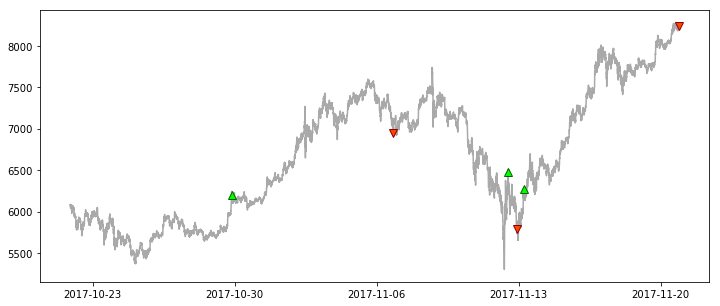

In [11]:
positions.plot(rate_sr, pos_sr)

# returns

In [12]:
from vectorbt import returns

Generate % returns out of positions. Takes into account fees.

In [13]:
posret_sr = returns.from_positions(rate_sr, pos_sr, 0.0015)
posret_sr.head()

date
2017-10-29 20:20:00   -0.001500
2017-11-06 19:30:00    0.120653
2017-11-12 11:25:00   -0.001500
2017-11-12 22:05:00   -0.106352
2017-11-13 06:45:00   -0.001500
dtype: float64

Position returns series (`posret`) inherits the structure of the position series and make them redundant. Because we apply fees, we get negative returns on long. If fees are zero, returns on long are also zero, but still included in the series. 

Generate hold returns.

In [14]:
returns.on_hold(rate_sr, 0.0015)

date
2017-10-21 21:25:00   -0.001500
2017-11-20 21:20:00    0.352959
dtype: float64

   count     mean       std       min     25%     50%       75%      max
0    6.0  0.05357  0.145439 -0.106352 -0.0015 -0.0015  0.090115  0.31162


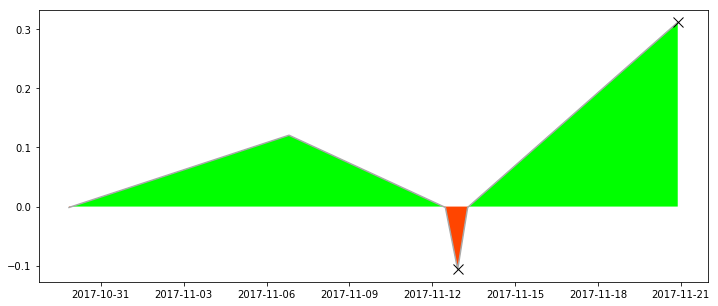

In [15]:
returns.plot(posret_sr)

# equity

In [16]:
from vectorbt import equity

Generate equity in base and quote currency from position returns

In [17]:
equity_df = equity.from_returns(rate_sr, posret_sr)
equity_df.head()

,base,quote
date,,
2017-10-21 21:25:00,NaN,NaN
2017-10-21 21:30:00,NaN,NaN
2017-10-21 21:35:00,NaN,NaN
2017-10-21 21:40:00,NaN,NaN
2017-10-21 21:45:00,NaN,NaN


Base and quote are NaN before the first entry or if no positions were taken

Visualize both equities

base
    count      mean         std         min         25%        50%       75%  \
0  6349.0 -31.43052  232.727894 -807.967544 -123.983405 -80.967544 -9.808395   

           max  
0  1629.392456  


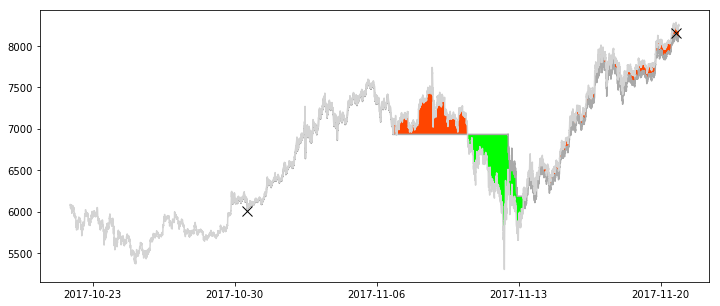

quote
    count      mean     std       min      25%       50%     75%       max
0  6349.0 -0.002905  0.0362 -0.104389 -0.01594 -0.011545 -0.0015  0.307279


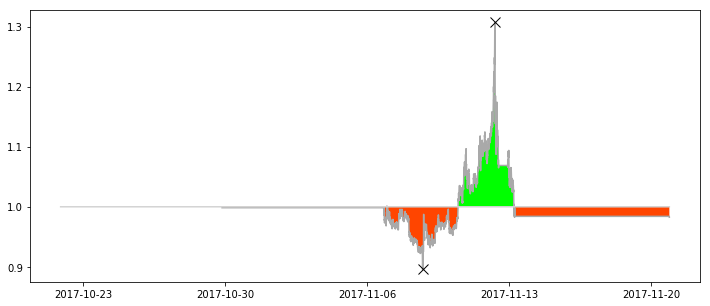

In [18]:
equity.plot(rate_sr, equity_df)

Equity diffs (`eqd`) are absolute returns if initial investment was 1. They are used in calculation of performance and risk/profit indicators such as sharpe ratio.

In [21]:
eqd_sr = equity.diffs(posret_sr)
eqd_sr.head()

date
2017-11-06 19:30:00    0.120472
2017-11-12 22:05:00   -0.118827
2017-11-20 21:20:00    0.310675
dtype: float64

# kpi

Every indicator uses equity diffs as input

In [22]:
from vectorbt import kpi
import json

In [23]:
kpi.print_summary(eqd_sr)

{
  "performance": {
    "profit": 0.31232050115137777,
    "averages": {
      "trade": 0.10410683371712592,
      "gain": 0.21557361453959778,
      "loss": 0.11882672792781779
    },
    "winrate": 0.6666666666666666,
    "payoff": 1.814184555098998,
    "PF": 3.628369110197996,
    "RF": 2.628369110197996
  },
  "risk/return profile": {
    "sharpe": 0.48372719169591677,
    "sortino": NaN,
    "maxdd": 0.11882672792781779
  }
}


# optimizer.gridsearch

The classic optimization method is grid search (or exhaustive search). It exhaustively generates candidates from a grid of parameter values and applies them on the series. 

This method brings some advantages:
- its simple to implement
- 2d-combinations can be visualized using heatmaps
- can be used to discover hidden patterns in combinations
- highly parallelizable

But also drawbacks are possible:
- not flexible enough to fit changing financial markets
- prone to overfitting
- no intermediate feedback

**Grid search consists of 5 levels:**

| Level | Operation | Result | Use cases |
|-|-|-|-|
| L1 | Calculate positions | `posmap` (dict) | Transformed into returns, equity or equity diffs |
| L2 | Calculate equity diffs | `eqdmap` (dict) | Used in calculation of indicators |
| L3 | Apply KPIs | `kpimap_sr` (series) | Used in comparing strategies, building a score or a matrix |
| L4 | Bind KPIs into a score | `scoremap_sr` (series) | Takes into account and examines multiple KPIs |
| L5 | Convert into a matrix | `matrix_df` (dataframe) | Constructs a heatmap |

At the end we will be able to compare performance of different trading strategies.

## L1
## posmap

Position series keyed by parameter combinations

In [24]:
from vectorbt.optimizer.gridsearch import posmap

Generate combinations of fast and slow SMA (from 1 to 100) and their resulting positions

In [25]:
sma_posmap = posmap.ma(rate_sr, 1, 100, 1, (0.01, 0.01), indicators.SMA)

ma-posmap
setup: ma_func = SMA, th = (0.01, 0.01)
grid: 1.000000 -> 100.000000 = 5050
calcs: 5050 ..
passed. 8.20s


Generate random positions of magnitude similar to the map above (to be comparable)

In [26]:
import math
n = math.ceil(np.median([len(pos_sr.index) for pos_sr in sma_posmap.values() if len(pos_sr.index) > 0]))
N = len(sma_posmap)
random_posmap = posmap.random(rate_sr, n, N)

random-posmap
setup: positions = ~26, N = 5050
calcs: 5050 ..
passed. 6.20s


## L2
## eqdmap

Translate each position series in the `posmap` into equity diffs

In [27]:
from vectorbt.optimizer.gridsearch import eqdmap

In [28]:
sma_eqdmap = eqdmap.from_posmap(rate_sr, sma_posmap, 0.0015)

eqdmap
setup: fees = 0.001500
calcs: 5050 ..
passed. 16.16s


In [29]:
random_eqdmap = eqdmap.from_posmap(rate_sr, random_posmap, 0.0015)

eqdmap
setup: fees = 0.001500
calcs: 5050 ..
passed. 14.25s


## L3 
## kpimap

Apply indicator (KPI) on each equity diffs series in the `eqdmap`

In [30]:
from vectorbt.optimizer.gridsearch import kpimap

In [31]:
sma_kpimap1_sr = kpimap.from_eqdmap(sma_eqdmap, kpi.expectancy)

expectancy-kpimap
calcs: 5050 ..
min (2, 3): -0.12458152267
max (9, 11): 0.406582071547
passed. 3.35s


In [32]:
sma_kpimap2_sr = kpimap.from_eqdmap(sma_eqdmap, kpi.sharpe)

sharpe-kpimap
calcs: 5050 ..
min (8, 12): -1.10455924516
max (32, 52): 1.28030214488
passed. 3.25s


In [33]:
random_kpimap_sr = kpimap.from_eqdmap(random_eqdmap, kpi.expectancy)

expectancy-kpimap
calcs: 5050 ..
min 1746: -0.0233012062283
max 3963: 0.0706928182365
passed. 3.19s


Compare KPI maps on basic properties and quantiles distribution

    count      mean       std       min       25%       50%       75%  \
0  5050.0  0.012042  0.011358 -0.023301  0.004036  0.011079  0.018958   
1  4543.0  0.073841  0.116389 -0.124582  0.002935  0.009545  0.100946   

        max  
0  0.070693  
1  0.406582  


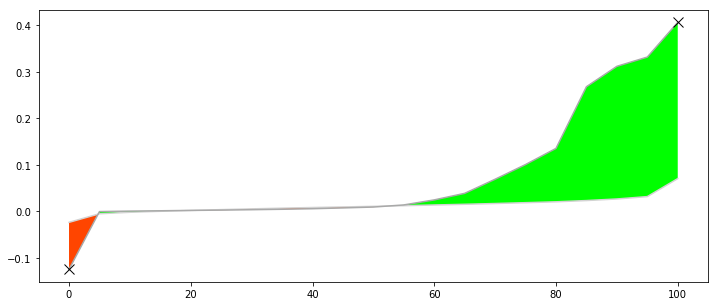

In [34]:
kpimap.compare(random_kpimap_sr, sma_kpimap1_sr)

## L4
## scoremap

Take into account multiple weighted indicators and generate a score from 1 to 100

In [35]:
from vectorbt.optimizer.gridsearch import scoremap

In [36]:
sma_scoremap_sr = scoremap.from_kpimaps([sma_kpimap1_sr, sma_kpimap2_sr], [2/3, 1/3], [False, False])

1-100-scoremap
min (1, 1): 1.0
max (37, 59): 73.733829533
passed. 0.01s


## L5 
## matrix

Reshape 2d-parameter grid into a matrix and display as a heatmap

In [37]:
from vectorbt.optimizer.gridsearch import matrix
from matplotlib import pyplot as plt
import pandas as pd

In [38]:
sma_matrix_df = matrix.from_map(sma_kpimap1_sr, symmetric=True).fillna(0)

100-100-matrix
passed. 1.89s


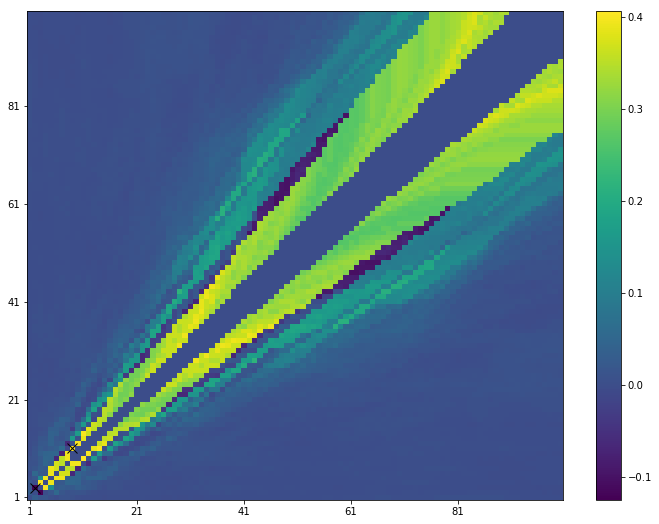

In [39]:
cmap = plt.cm.viridis
norm = plt.Normalize()
matplotlib.rcParams['figure.figsize'] = (12, 9)
matrix.plot(sma_matrix_df, cmap, norm)

Compare KPI distribution to that of random map

    count      mean       std       min       25%       50%       75%  \
0  4543.0  0.073841  0.116389 -0.124582  0.002935  0.009545  0.100946   

        max  
0  0.406582  


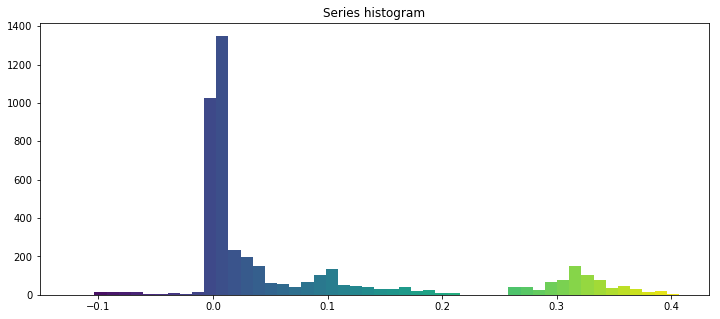

In [40]:
matplotlib.rcParams['figure.figsize'] = (12, 5)
graphics.plot_hist(sma_kpimap1_sr.dropna(), cmap, norm)

    count      mean       std       min       25%       50%       75%  \
0  5052.0  0.012093  0.012786 -0.124582  0.004035  0.011079  0.018965   

        max  
0  0.406582  


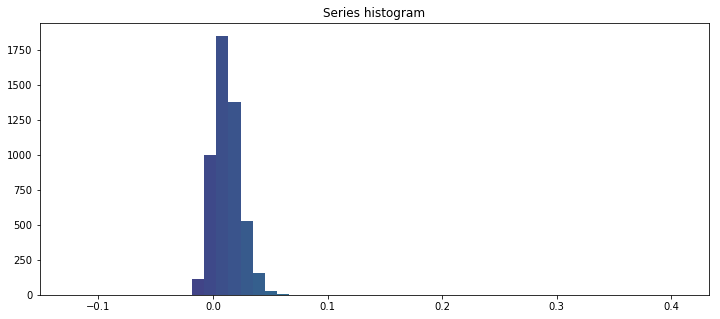

In [41]:
# Adjust bounds
to_plot = random_kpimap_sr.append(pd.Series(sma_kpimap1_sr.min())).append(pd.Series(sma_kpimap1_sr.max()))
graphics.plot_hist(to_plot, cmap, norm)